In [ ]:
#Importing the required libraries
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
import shutil
from pathlib import Path
from tqdm import tqdm
import os

# **Dataset Description and Data Pre-processing**

In [ ]:
#Definingpaths to TFRecord files for Monet paintings and real photos
monet_tf_path = "/ML_Project_Datasets/monet_tfrec/*.tfrec"
photo_tf_path = "/ML_Project_Datasets/photo_tfrec/*.tfrec"
#Listing the TFRecord file paths for both datasets
monet_tf = tf.data.Dataset.list_files(monet_tf_path)
photo_tf = tf.data.Dataset.list_files(photo_tf_path)
#Printing number of TFRecord files found for each dataset
print('Monet TFRecord Files: ', len(monet_tf))
print('Photo TFRecord Files: ', len(photo_tf))


Monet TFRecord Files:  5
Photo TFRecord Files:  20


In [ ]:
#Setting image dimensions width, height for all training sample
IMAGE_SIZE = [256, 256]
AUTOTUNE = tf.data.AUTOTUNE#enabling parallel data loading for performance
#Defining a function for decoding and preprocessing images
def decode(img, training):
    #decoding JPEG image into RGB format
    img = tf.image.decode_jpeg(img, channels=3)

    if training:
        #resizing image slightly larger for jitter effect
        img = tf.image.resize(img, [286, 286]) 
        #cropping back to original size for randomness
        img = tf.image.random_crop(img, size=[256, 256, 3]) 
        #flipping image horizontally to improve variation
        img = tf.image.random_flip_left_right(img) 
    
    #Normalizing pixel values to range [-1, 1]
    img = (tf.cast(img, tf.float32) / 127.5) - 1
    #reshaping image tensor to expected dimensions
    img = tf.reshape(img, [*IMAGE_SIZE, 3]) 
    return img
#Defining how to read individual TFRecord entries and extract the imag
def read_tfrecord(tfrecord, training):
    format_tf = {
        'image_name': tf.io.FixedLenFeature([], tf.string),
        'image': tf.io.FixedLenFeature([], tf.string),
        'target': tf.io.FixedLenFeature([], tf.string),
    }
    #parsing the TFRecord to extract image fields
    ex = tf.io.parse_single_example(tfrecord, format_tf)
    #decoding the image with preprocessing
    image = decode(ex['image'], training)
    return image
#Defining a function to load an entire dataset from TFRecord paths
def load_dataset(tf_files, training=False):
    #creating a TFRecordDataset from file paths
    dataset = tf.data.TFRecordDataset(tf_files)
    #mapping each record to the read_tfrecord function with preprocessing
    dataset = dataset.map(lambda x: read_tfrecord(x, training), num_parallel_calls=AUTOTUNE)
    return dataset

In [ ]:
#counting and printing the number of images in the Monet dataset
print("Monet Images: ", sum(1 for _ in tf.data.TFRecordDataset(monet_tf)))
#counting and printing the number of images in the Photo dataset
print('Photo Images: ', sum(1 for _ in tf.data.TFRecordDataset(photo_tf)))
#creating the training dataset for Monet images by applying shuffling, batching with size 1, repeating for infinite epochs, and prefetching for performance
monet_ds = load_dataset(monet_tf, training=True).shuffle(512).batch(1).repeat().prefetch(tf.data.AUTOTUNE)
#creating the training dataset for Photo images with the same settings
photo_ds = load_dataset(photo_tf, training=True).shuffle(512).batch(1).repeat().prefetch(tf.data.AUTOTUNE)
#creating the test dataset for Monet images with no shuffle or repeat
test_monet_ds = load_dataset(monet_tf, training=False).batch(1).prefetch(tf.data.AUTOTUNE)
#creating the test dataset for Photo images with no shuffle or repeat
test_photo_ds = load_dataset(photo_tf, training=False).batch(1).prefetch(tf.data.AUTOTUNE)

Monet Images:  300
Photo Images:  7038


In [ ]:
#taking one sample from the Monet dataset to check shape and data type
for img in monet_ds.take(1):
    print("Sample Monet Image Shape:", img.shape)
    print("Image dtype:", img.dtype)

Sample Monet Image Shape: (1, 256, 256, 3)
Image dtype: <dtype: 'float32'>


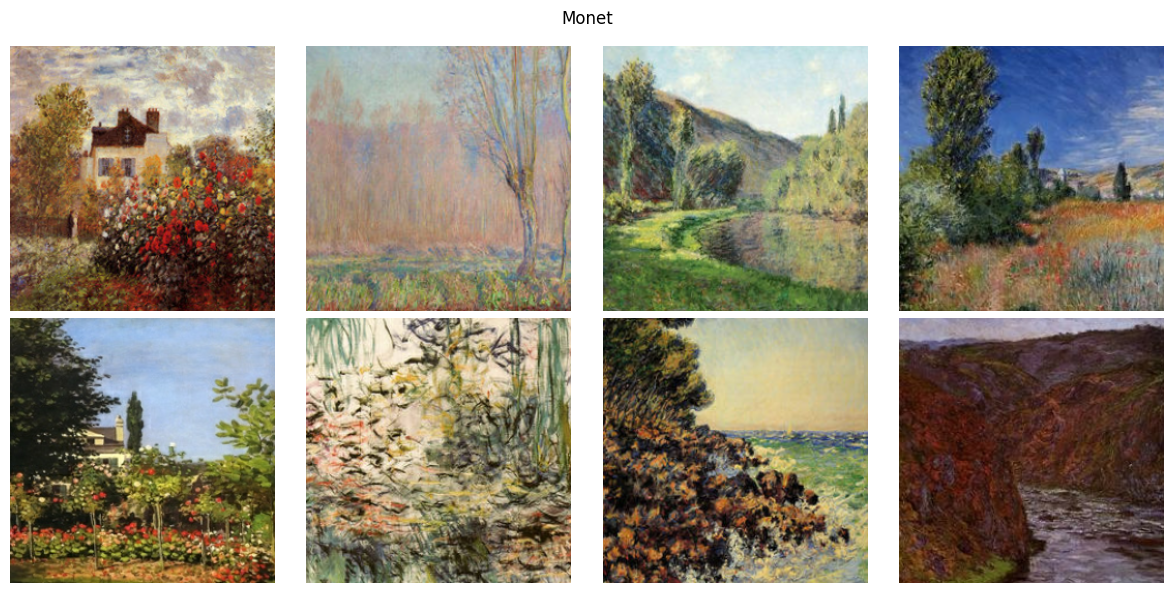

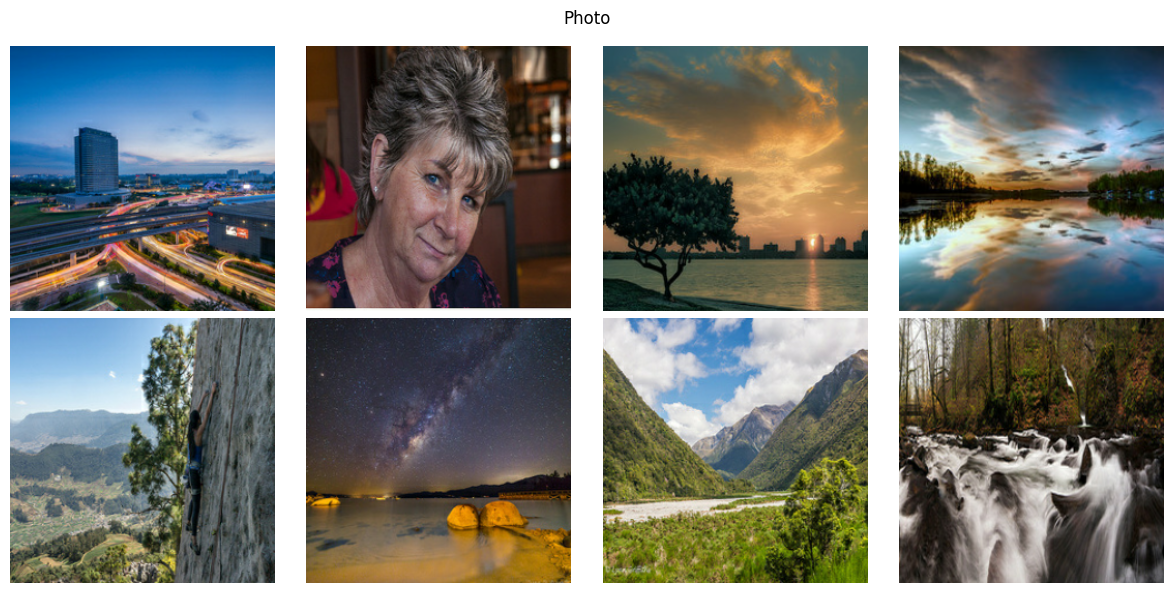

In [ ]:
#taking one sample image from each dataset to use for testing or display
ex_monet, ex_photo = next(iter(monet_ds)), next(iter(photo_ds))
#defining a function to show a batch of 8 images from a dataset
def show_img(ds, title):
    plt.figure(figsize=(12,6))
    for i, img in enumerate(ds.take(8)):
        plt.subplot(2, 4, i+1)
        #converting image pixel values from [-1, 1] to [0, 1] for visualization
        plt.imshow(tf.squeeze(img, axis=0) * 0.5 + 0.5)
        plt.axis('off')
    plt.suptitle(title)
    plt.tight_layout()
    plt.show()
#displaying 8 Monet paintings from the dataset
show_img(monet_ds, 'Monet')
#displaying 8 real photo images from the dataset
show_img(photo_ds, 'Photo')

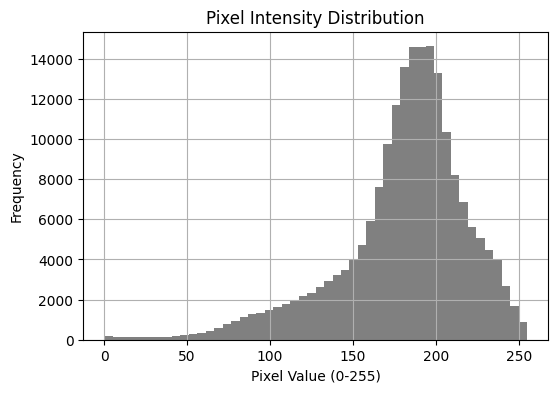

In [ ]:
#taking one sample image from the Monet dataset
sample_img = next(iter(monet_ds))[0]
#plotting the distribution of pixel intensity values after normalization is reversed
plt.figure(figsize=(6, 4))
plt.hist(((sample_img.numpy() + 1) * 127.5).flatten(), bins=50, color='gray')
plt.title("Pixel Intensity Distribution")
plt.xlabel("Pixel Value (0-255)")
plt.ylabel("Frequency")
plt.grid(True)
plt.show()


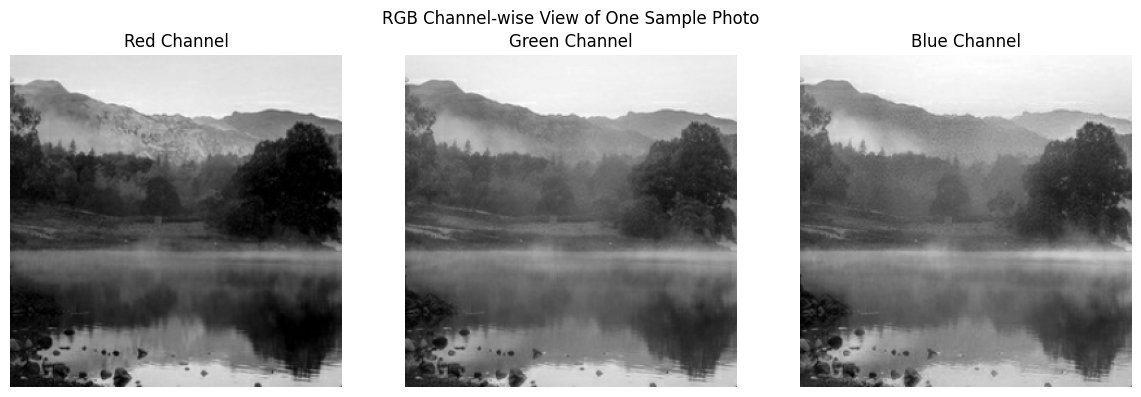

In [ ]:
#RGB Channel Visualization
#taking one photo image sample and rescaling pixel values from [-1, 1] to [0, 1] for display
img_rgb = (next(iter(photo_ds))[0] + 1) / 2  
#defining labels for each color channel
channels = ['Red', 'Green', 'Blue']
#creating a figure to display the three channels side by side
plt.figure(figsize=(12, 4))
#looping through each color channel and displaying it as a grayscale image
for i in range(3):
    plt.subplot(1, 3, i + 1)
    plt.imshow(img_rgb[:, :, i], cmap='gray')
    plt.title(f'{channels[i]} Channel')
    plt.axis('off')
plt.suptitle("RGB Channel-wise View of One Sample Photo")
plt.tight_layout()
plt.show()


### CycleGAN Architecture

In [ ]:
#defining a function to create an upsampling block for the generator
def upsample(filters, size, dropout=False):
    result = keras.Sequential()
    #adding a transposed convolution layer to increase spatial dimensions
    result.add(layers.Conv2DTranspose(filters, size, strides=2, padding='same'))
    #applying group normalization for stable training
    result.add(layers.GroupNormalization(1)) 
    #adding dropout for regularization
    if dropout:
        result.add(layers.Dropout(0.3))
    #applying ReLU activation to introduce non-linearity
    result.add(layers.ReLU())
    return result
#defining a function to create a downsampling block for the generator or discriminator
def downsample(filters, size, inorm=True):
    result = keras.Sequential()
    #adding a convolutional layer to reduce spatial dimensions
    result.add(layers.Conv2D(filters, size, strides=2, padding='same'))
    #applying group normalization
    if inorm:
        result.add(layers.GroupNormalization(1)) 
    #applying LeakyReLU activation for better gradient flow
    result.add(layers.LeakyReLU())
    return result
    

In [ ]:
#defining the generator model which transforms an input image to a stylized output image
def generator(input_shape=(256, 256, 3)):
    #creating an input layer with the specified image shape
    inputs = keras.Input(shape=input_shape)
    #building a list of downsampling layers to extract features and reduce image dimensions
    downsample_stack = [
        downsample(64, 4, inorm=False),#reducing to 128x128 with 64 filters without normalization
        downsample(128, 4),#reducing to 64x64 with 128 filters
        downsample(256, 4),#reducing to 32x32 with 256 filters
        downsample(512, 4),#reducing to 16x16 with 512 filters
        downsample(512, 4),#reducing to 8x8
        downsample(512, 4),#reducing to 4x4
        downsample(512, 4),#reducing to 2x2
        downsample(512, 4),#reducing to 1x
    ]
    #building a list of upsampling layers to reconstruct the image and refine features
    upsample_stack = [
        upsample(512, 4, dropout=True),#increasing to 2x2
        upsample(512, 4, dropout=True),#increasing to 4x4
        upsample(512, 4, dropout=True),#increasing to 8x8
        upsample(512, 4),#increasing to 16x16
        upsample(256, 4),#increasing to 32x32
        upsample(128, 4),#increasing to 64x64
        upsample(64, 4)#increasing to 128x128
    ]
    #final transposed convolution layer to return to original image size and 3 RGB channels
    fc = layers.Conv2DTranspose(3, 4, strides=2, padding='same', activation='tanh') 
    #applying downsampling layers and saving skip connections
    x = inputs
    skips = []
    for down in downsample_stack:
        x = down(x)
        skips.append(x)
    #reversing skip connections except the last one    
    skips = reversed(skips[:-1])

     #applying upsampling layers and concatenating with corresponding skip connections
    for up, skip in zip(upsample_stack, skips):
        x = up(x)
        x = layers.Concatenate()([x, skip])
    #applying the final convolution layer to get the output image
    x = fc(x)
    #creating the Keras model with input and output
    return keras.Model(inputs=inputs, outputs=x, name='generator')

In [ ]:
#defining the discriminator model that classifies image patches as real or fa
def discriminator(input_shape=(256, 256, 3)):
    #creating the input layer for the image
    inputs = layers.Input(shape=input_shape, name='input_img')
    x = inputs
    #creating a stack of downsampling layers to extract features and reduce spatial size
    ds_stack = [
        downsample(64, 4, inorm=False), 
        downsample(128, 4), 
        downsample(256, 4), 
    ]
    #applying each downsampling layer to the input
    for ds in ds_stack:
        x = ds(x)
    #creating a sequential block to finish the discriminator
    result = keras.Sequential([
        #adding a convolution layer to expand feature depth
        layers.Conv2D(512, 4, strides=1, padding='same'), 
        layers.GroupNormalization(1), 
        layers.LeakyReLU(),
        layers.Conv2D(1, 4, strides=1, padding='same'),
    ])
    #applying the final part of the model
    x = result(x)
    #creating the Keras model with input and output
    return tf.keras.Model(inputs=inputs, outputs=x, name='discriminator')

In [ ]:
#creating the generator model that converts photo images into Monet-style images
monet_gen = generator() 
#creating the generator model that converts Monet paintings into realistic photo
photo_gen = generator() 
#creating the discriminator model to classify real vs generated Monet paintings
monet_discrim = discriminator() 
#creating the discriminator model to classify real vs generated photo images
photo_discrim = discriminator() 
#printing the summary of the Monet generator model
monet_gen.summary()
#printing the summary of the Monet discriminator model
monet_discrim.summary()


Model: "generator"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 256, 256, 3)]        0         []                            
                                                                                                  
 sequential (Sequential)     (None, 128, 128, 64)         3136      ['input_1[0][0]']             
                                                                                                  
 sequential_1 (Sequential)   (None, 64, 64, 128)          131456    ['sequential[0][0]']          
                                                                                                  
 sequential_2 (Sequential)   (None, 32, 32, 256)          525056    ['sequential_1[0][0]']        
                                                                                         

In [ ]:
print("\nTotal Trainable Parameters:")
print("Monet Generator:", monet_gen.count_params())
print("Photo Generator:", photo_gen.count_params())
print("Monet Discriminator:", monet_discrim.count_params())
print("Photo Discriminator:", photo_discrim.count_params())



Total Trainable Parameters:
Monet Generator: 54420483
Photo Generator: 54420483
Monet Discriminator: 2766529
Photo Discriminator: 2766529


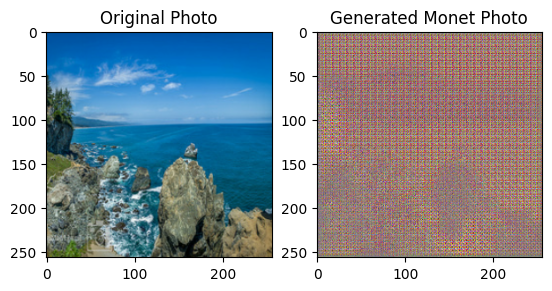

In [ ]:
to_monet = monet_gen(ex_photo)

plt.subplot(121)
plt.title('Original Photo')
plt.imshow(ex_photo[0] * 0.5 + 0.5)

plt.subplot(122)
plt.title('Generated Monet Photo')
plt.imshow(to_monet[0] * 0.5 + 0.5)

In [ ]:
# SSIM Comparison
from tensorflow.image import ssim

real_img = ex_photo[0]
gen_img = to_monet[0]

ssim_score = ssim((real_img + 1) / 2, (gen_img + 1) / 2, max_val=1.0)
print("SSIM between Original and Generated Monet Image:", ssim_score.numpy())


SSIM between Original and Generated Monet Image: 0.028259689


# **Training and Testing Process**

In [14]:
class CycleGAN(keras.Model):
    def __init__(self, monet_gen, photo_gen, monet_dis, photo_dis, lambda_cycle=10):
        super(CycleGAN, self).__init__()
        self.monet_gen = monet_gen
        self.monet_dis = monet_dis
        self.photo_gen = photo_gen
        self.photo_dis = photo_dis
        self.lambda_cycle = lambda_cycle
    def compile(self, m_g_opt, p_g_opt, m_dis_opt, p_dis_opt, gen_loss_fn, dis_loss_fn, cycle_loss_fn, identity_loss_fn):
        ''' 
            Compile optimizers and loss functions
            Args:
                m_g_opt, p_g_opt: monet / photo generator optimizer
                m_dis_opt, p_dis_opt: monet / photo discriminator optimizer
                gen_loss_fn, dis_loss_fn: generator / discriminator loss function
                cycle_loss_fn, identity_loss_fn: cycle / identity loss function
        '''
        super(CycleGAN, self).compile()
        self.m_g_opt, self.p_g_opt = m_g_opt, p_g_opt # gen optimizers
        self.m_dis_opt, self.p_dis_opt = m_dis_opt, p_dis_opt # dis optimizers
        self.gen_loss_fn, self.dis_loss_fn = gen_loss_fn, dis_loss_fn # loss functions
        self.cycle_loss_fn, self.identity_loss_fn = cycle_loss_fn, identity_loss_fn # loss functions

    def apply_gradients(self, tape, losses, models, optimizers):

        for loss, model, opt in zip(losses, models, optimizers):
            grad = tape.gradient(loss, model.trainable_variables)
            opt.apply_gradients(zip(grad, model.trainable_variables))
            
    def train_step(self, batch):
        monet, photo = batch

        with tf.GradientTape(persistent=True) as tape:
            # Generator
            fake_monet = self.monet_gen(photo, training=True) # photo -> monet
            cycled_photo = self.photo_gen(fake_monet, training=True) # photo -> monet -> photo

            fake_photo = self.photo_gen(monet, training=True) # monet -> photo
            cycled_monet = self.monet_gen(fake_photo, training=True) # monet -> photo -> monet

            same_monet = self.monet_gen(monet, training=True) # monet -> monet
            same_photo = self.photo_gen(photo, training=True) # photo -> photo

            # Discriminator (are our real / generated photos real?)
            dis_real_monet = self.monet_dis(monet, training=True) 
            dis_real_photo = self.photo_dis(photo, training=True)
            
            dis_fake_monet = self.monet_dis(fake_monet, training=True)
            dis_fake_photo = self.photo_dis(fake_photo, training=True)

            # Generator loss functions
            monet_gen_loss = self.gen_loss_fn(dis_fake_monet)
            photo_gen_loss = self.gen_loss_fn(dis_fake_photo)

            cycle_loss = self.cycle_loss_fn(monet, cycled_monet, self.lambda_cycle) + self.cycle_loss_fn(photo, cycled_photo, self.lambda_cycle)
            total_monet_gen_loss = monet_gen_loss + cycle_loss + self.identity_loss_fn(monet, same_monet, self.lambda_cycle)
            total_photo_gen_loss = photo_gen_loss + cycle_loss + self.identity_loss_fn(photo, same_photo, self.lambda_cycle)

            # Discriminator loss functions
            monet_dis_loss = self.dis_loss_fn(dis_real_monet, dis_fake_monet)
            photo_dis_loss = self.dis_loss_fn(dis_real_photo, dis_fake_photo)

        # Calc + apply gradients :o
        self.apply_gradients(tape, losses=[total_monet_gen_loss, total_photo_gen_loss, monet_dis_loss, photo_dis_loss],
                            models=[self.monet_gen, self.photo_gen, self.monet_dis, self.photo_dis],
                            optimizers=[self.m_g_opt, self.p_g_opt, self.m_dis_opt, self.p_dis_opt])
        return {
            'monet_gen_loss': total_monet_gen_loss,
            'photo_gen_loss': total_photo_gen_loss,
            'monet_dis_loss': monet_dis_loss,
            'photo_dis_loss': photo_dis_loss
        }

In [ ]:
def dis_loss(real, gen):
    '''
        real_loss: compares real imgs to matrix of 1s
        gen_loss: compares fake imgs to matrix of 0s

        returns avg of loss
    '''
    # Loss for real images
    real_loss = tf.keras.losses.BinaryCrossentropy(from_logits=True, reduction=tf.keras.losses.Reduction.NONE)(tf.ones_like(real), real)
    # Loss for generated images
    gen_loss = tf.keras.losses.BinaryCrossentropy(from_logits=True, reduction=tf.keras.losses.Reduction.NONE)(tf.zeros_like(gen), gen)
    # (goal is to have discriminator output 0 for generated images)
    return (real_loss + gen_loss) * 0.5 

def gen_loss(gen):
    '''compare gen image to matrix of 1s (gen goal is discrim outputs only real (1) in the matrix)'''
    return tf.keras.losses.BinaryCrossentropy(from_logits=True, reduction=tf.keras.losses.Reduction.NONE)(tf.ones_like(gen), gen)

def cycle_loss(real, cycled, _lambda):
    '''average of difference between real image and cycled image'''
    loss = tf.reduce_mean(tf.abs(real - cycled))
    return _lambda * loss

def identity_loss(real, same, _lambda):
    '''average of difference between real image and same regenerated image'''
    loss = tf.reduce_mean(tf.abs(real - same))
    return _lambda * 0.5 * loss

In [ ]:
# Defining the CycleGAN model
lr = 2e-4
decay = 25000
epochs= 50

# Defining the learning rate schedule for the optimizers
lr_sched = tf.keras.optimizers.schedules.PolynomialDecay(initial_learning_rate=lr,
                                                            decay_steps=decay,
                                                            end_learning_rate=0.0,
                                                            power=1.0)

# Polynomial decay schedule for learning rate
monet_gen_optimizer = tf.keras.optimizers.Adam(learning_rate=lr_sched, beta_1=0.5)
photo_gen_optimizer = tf.keras.optimizers.Adam(learning_rate=lr_sched, beta_1=0.5)
monet_dis_optimizer = tf.keras.optimizers.Adam(learning_rate=lr_sched, beta_1=0.5)
photo_dis_optimizer = tf.keras.optimizers.Adam(learning_rate=lr_sched, beta_1=0.5)

In [ ]:
# Instantiate the CycleGAN model
model = CycleGAN(monet_gen, photo_gen, monet_discrim, photo_discrim)

# Compile the model with optimizers and loss functions
model.compile(monet_gen_optimizer, photo_gen_optimizer, monet_dis_optimizer, photo_dis_optimizer, 
              gen_loss, dis_loss, cycle_loss, identity_loss)

# Training the CycleGAN model
history = model.fit(tf.data.Dataset.zip((monet_ds, photo_ds)), epochs=epochs, steps_per_epoch=300)


Epoch 1/50
300/300 [==============================] - 983s 3s/step - monet_gen_loss: 4.8375 - photo_gen_loss: 4.7778 - monet_dis_loss: 0.7186 - photo_dis_loss: 0.7269
Epoch 2/50
300/300 [==============================] - 929s 3s/step - monet_gen_loss: 3.1473 - photo_gen_loss: 3.1438 - monet_dis_loss: 0.6741 - photo_dis_loss: 0.6869
Epoch 3/50
300/300 [==============================] - 929s 3s/step - monet_gen_loss: 2.8155 - photo_gen_loss: 2.8279 - monet_dis_loss: 0.6557 - photo_dis_loss: 0.6653
Epoch 4/50
300/300 [==============================] - 927s 3s/step - monet_gen_loss: 2.5910 - photo_gen_loss: 2.5640 - monet_dis_loss: 0.6481 - photo_dis_loss: 0.6651
Epoch 5/50
300/300 [==============================] - 930s 3s/step - monet_gen_loss: 2.4496 - photo_gen_loss: 2.4448 - monet_dis_loss: 0.6491 - photo_dis_loss: 0.6625
Epoch 6/50
300/300 [==============================] - 939s 3s/step - monet_gen_loss: 2.3396 - photo_gen_loss: 2.3170 - monet_dis_loss: 0.6415 - photo_dis_loss: 0.65

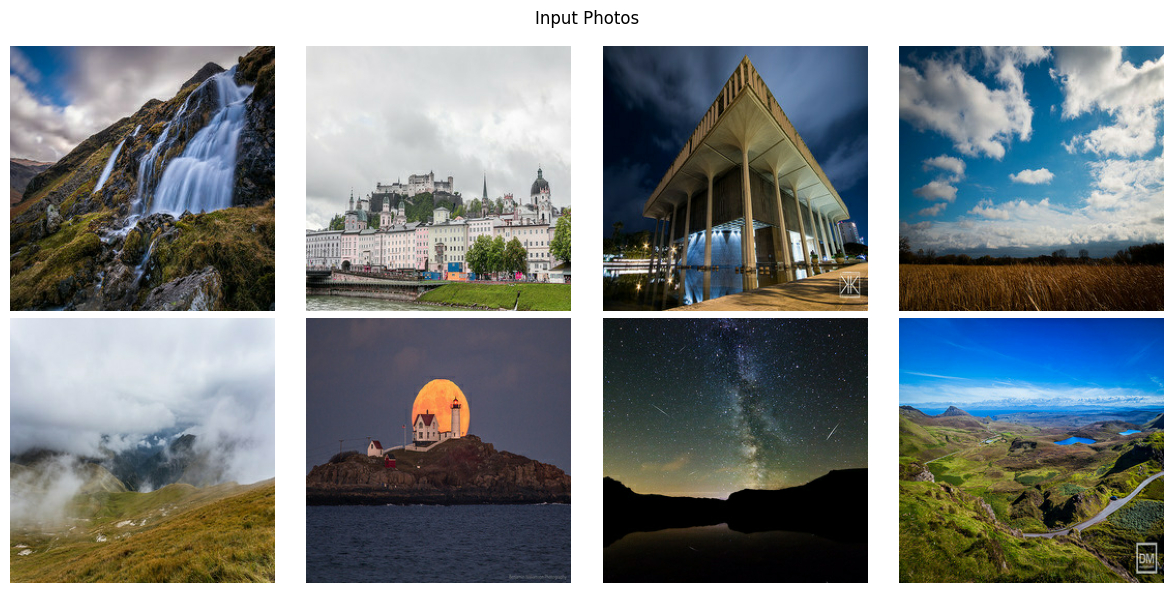

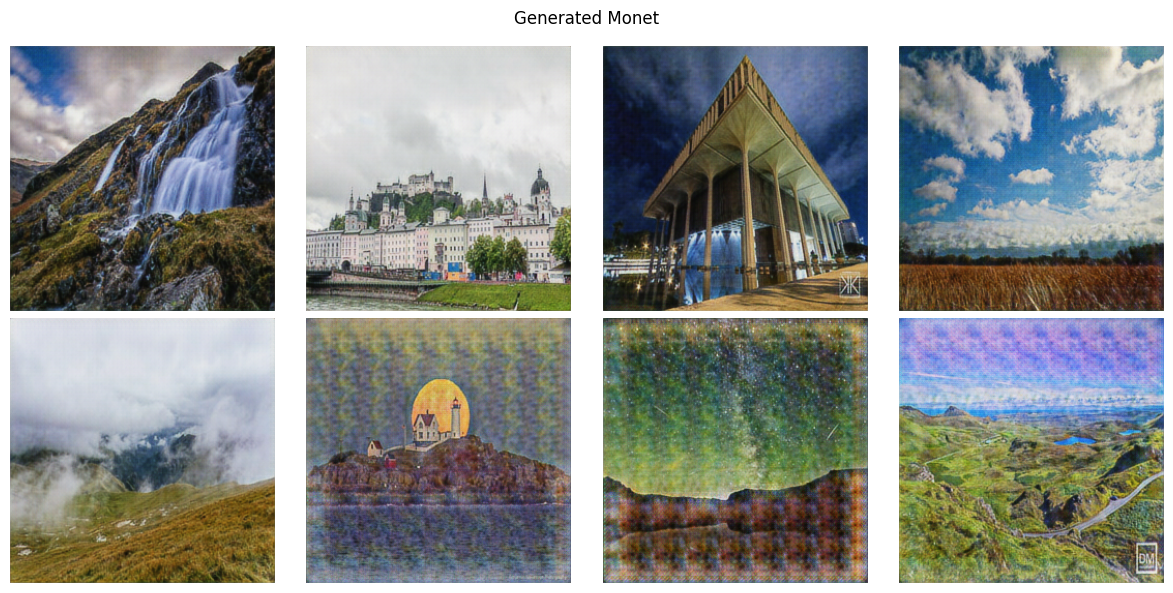

In [ ]:
# Displaying the generated images
imgs = list(test_photo_ds.take(8))

def show_img(title, generated=False):
    plt.figure(figsize=(12,6))
    for i, img in enumerate(imgs):
        plt.subplot(2, 4, i+1)
        if generated:
            out = monet_gen(img, training=False)[0].numpy()
            plt.imshow((out * 127.5 + 127.5).astype(np.uint8))
        else:
            plt.imshow(tf.squeeze(img, axis=0) * 0.5 + 0.5)
        plt.axis('off')
    plt.suptitle(title)
    plt.tight_layout()
    plt.show()

show_img('Input Photos')
show_img('Generated Monet', True)

# **Evaluation Metrics**

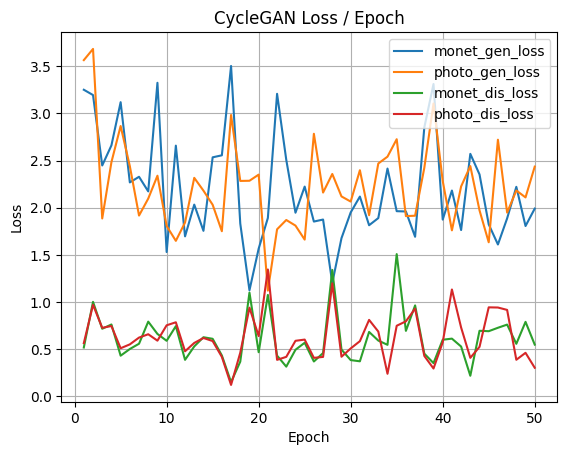

In [ ]:
for name, loss in history.history.items():
    # Calculate the average loss for each epoch and convert to numpy
    loss_avg = [tf.reduce_mean(l).numpy() for l in loss]
    plt.plot(range(1, len(loss_avg)+1), loss_avg, label=name)
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('CycleGAN Loss / Epoch')
plt.legend()
plt.grid(True)
plt.show()

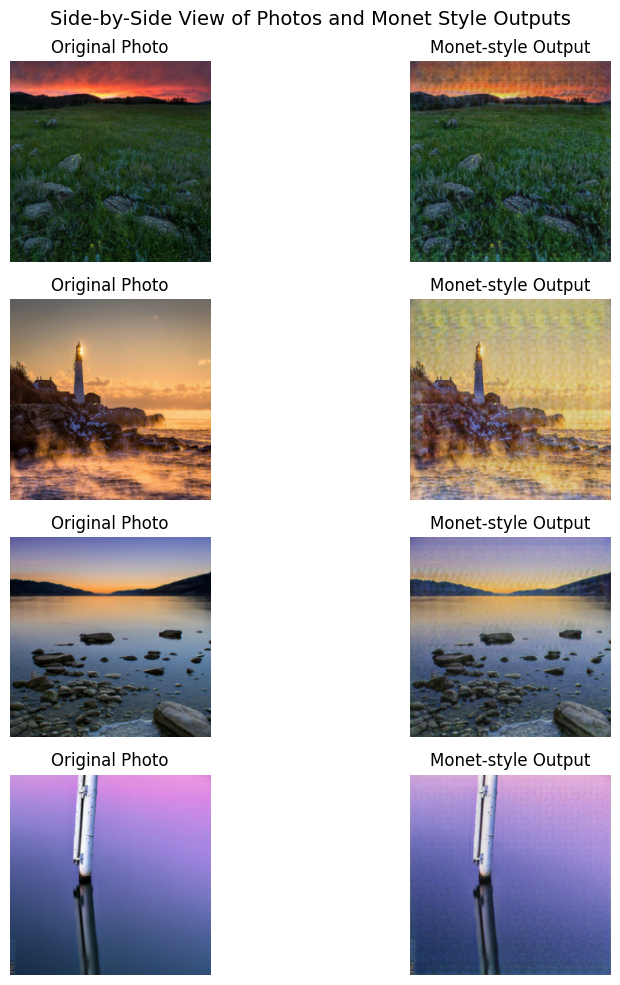

In [ ]:
# Side-by-Side Comparison of Photo and Monet Output
fig, axs = plt.subplots(4, 2, figsize=(10, 10))
for i in range(4):
    photo = next(iter(photo_ds))
    monet_style = monet_gen(photo, training=False)

    axs[i, 0].imshow((photo[0] + 1) / 2)
    axs[i, 0].set_title("Original Photo")
    axs[i, 0].axis("off")

    axs[i, 1].imshow((monet_style[0] + 1) / 2)
    axs[i, 1].set_title("Monet-style Output")
    axs[i, 1].axis("off")

plt.suptitle("Side-by-Side View of Photos and Monet Style Outputs", fontsize=14)
plt.tight_layout()
plt.show()


**Discriminator Patch Map Visualization:** This plot displays the original input photo, the discriminator’s patch map output, and the corresponding Monet-style generated image. The patch map highlights the discriminator’s response (real vs. fake) across different regions of the image.

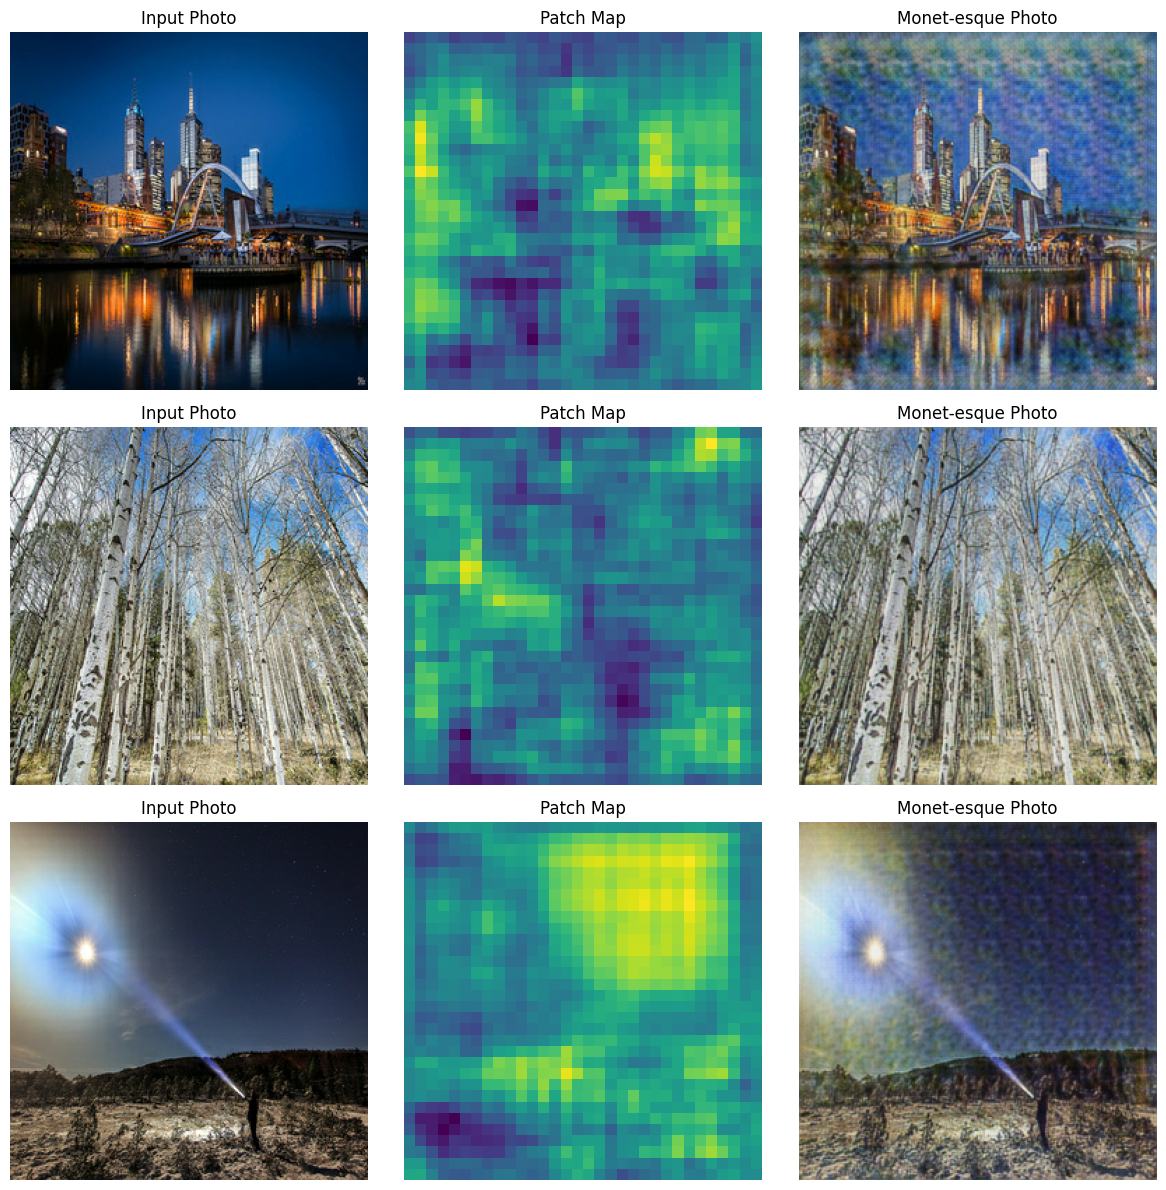

In [ ]:
# Generating Monet-style images and their corresponding patch maps
imgs = list(test_photo_ds.take(3))
gen_imgs = [monet_gen(img, training=False) for img in imgs]
patch_outs = [monet_discrim(gen_img, training=False) for gen_img in gen_imgs]
patch_outs = [tf.squeeze(patch_out, axis=[0,3]) for patch_out in patch_outs]


plt.figure(figsize=(12,12))
subplots = int(len(imgs)) * 3

for i in range(len(imgs)):
    plt.subplot(len(imgs), 3, i * 3 + 1)
    plt.imshow(tf.squeeze(imgs[i], axis=0) * 0.5 + 0.5)
    plt.title('Input Photo')
    plt.axis('off')

    plt.subplot(len(imgs), 3, i * 3 + 2)
    plt.imshow(tf.squeeze(patch_outs[i]), cmap='viridis')
    plt.title('Patch Map')
    plt.axis('off')
    
    plt.subplot(len(imgs), 3, i * 3 + 3)
    plt.imshow(tf.squeeze(gen_imgs[i], axis=0) * 0.5 + 0.5)
    plt.title('Monet-esque Photo')
    plt.axis('off')

plt.tight_layout()
plt.show()

In [3]:
import shutil

In [4]:
shutil.make_archive('/kaggle/working/images', 'zip', '/kaggle/input/images')

'/kaggle/working/images.zip'